# Step by Step Computation of Transition Matrix for Understanding Markov Chains
Data used can be downloaded from [https://digital.csic.es/handle/10261/332007](https://)

In [12]:
# Libraries
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
# access the google drive contents
from google.colab import drive
drive.mount('/content/drive')
# Change the path name where the data is kept in the google drive and allow the access
import os
os.chdir("drive/My Drive/Marcov_Chain")

Mounted at /content/drive


In [3]:
# read the netcdf dataset (spei12 dataset has been croped according to indian mainland)
dset =  xr.open_dataset('ind_spei12_2015.nc')
dset

<xarray.Dataset>
Dimensions:  (time: 1380, lat: 70, lon: 70)
Coordinates:
  * lon      (lon) float64 65.25 65.75 66.25 66.75 ... 98.25 98.75 99.25 99.75
  * lat      (lat) float64 5.25 5.75 6.25 6.75 7.25 ... 38.25 38.75 39.25 39.75
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 2015-12-16
Data variables:
    spei     (time, lat, lon) float32 ...
Attributes: (12/14)
    Title:        Global 12-months SPEI, z-values, 0.5 degree
    Version:      2.5
    Id:           ./outputNcdf/spei12.nc
    Summary:      Global dataset of the Standardized\n\t  Precipitation-Evapo...
    Keywords:     drought, climatology, SPEI, Standardized\n\t  Precipitation...
    Institution:  Consejo Superior de Investigaciones\n\t          Científica...
    ...           ...
    Software:     Created in R using the SPEI package\n\t          (https://c...
    Call:         spei.nc(sca=i, inPre=./inputData/cru_ts3.24.01.1901.2015.pr...
    Date:         Tue Jun 20 12:04:21 2017
    Reference:    Beguería S., Vicente-Serrano S., Reig F., Latorre B. (2014)...
    Reference2:   Vicente-Serrano S.M., Beguería S., López-Moreno J.I. (2010)...
    Reference3:   Beguería S., Vicente-Serrano S., Angulo-Martínez M. (2010) ...

In [4]:
# selection of spei12 december
spei_data =  dset['spei'][11:1380:12]
spei_data

<xarray.DataArray 'spei' (time: 115, lat: 70, lon: 70)>
[563500 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 65.25 65.75 66.25 66.75 ... 98.25 98.75 99.25 99.75
  * lat      (lat) float64 5.25 5.75 6.25 6.75 7.25 ... 38.25 38.75 39.25 39.75
  * time     (time) datetime64[ns] 1901-12-16 1902-12-16 ... 2015-12-16
Attributes:
    units:      z-values
    long_name:  Standardized Precipitation-Evapotranspiration Index

In [5]:
# selecting the first 100 years of spei12 december
spei100 = spei_data[0:100]
spei100

<xarray.DataArray 'spei' (time: 100, lat: 70, lon: 70)>
[490000 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 65.25 65.75 66.25 66.75 ... 98.25 98.75 99.25 99.75
  * lat      (lat) float64 5.25 5.75 6.25 6.75 7.25 ... 38.25 38.75 39.25 39.75
  * time     (time) datetime64[ns] 1901-12-16 1902-12-16 ... 2000-12-16
Attributes:
    units:      z-values
    long_name:  Standardized Precipitation-Evapotranspiration Index

In [6]:
### Categorization of dryness/wetness grade by the SPEI. [DOI: 10.1002/joc.3701]
# Extremely dryness (ED) Less than −2; value=-3
# Severe dryness (SD) −1.99 to −1.5; value=-2
# Moderate dryness (MD) −1.49 to −1.0; value=-1
# Near normal (NN) −1.0 to 1.0;  value=0
# Moderate wettness (MW) 1.0 to 1.49; value=1
# Severe wettness (SW) 1.50 to 1.99;  value=2
# Extremely wettness (EW) More than 2;  value=3

In [7]:
def sign(dataset):
    """function to categorise SPEI value"""
    for days in range(0,len(dataset)):
        for lat in range(0,len(dataset[days])):
            for lon in range(0,len(dataset[days][lat])):
                if dataset[days][lat][lon] <=-2:
                    dataset[days][lat][lon]=-3
                elif dataset[days][lat][lon] >-2 and dataset[days][lat][lon]<-1.5:
                    dataset[days][lat][lon]=-2
                elif dataset[days][lat][lon] >=-1.5 and dataset[days][lat][lon]<-1:
                    dataset[days][lat][lon]=-1
                elif dataset[days][lat][lon] >=-1 and dataset[days][lat][lon]<1:
                    dataset[days][lat][lon]=0
                elif dataset[days][lat][lon] >=1 and dataset[days][lat][lon]<1.5:
                    dataset[days][lat][lon]=1
                elif dataset[days][lat][lon] >=1.5 and dataset[days][lat][lon]<2:
                    dataset[days][lat][lon]=2
                if dataset[days][lat][lon] >=2:
                    dataset[days][lat][lon]=3

    return dataset

In [8]:
# applying the sign function to the spei100
array_cat= xr.apply_ufunc(sign, spei100)
#array_cat

In [9]:
# converting the xarray to numpy array for the further experimentation
np_array = np.array(array_cat)
np_array.shape

(100, 70, 70)

In [10]:
np_reshape = np.moveaxis(np_array, 0, 2)
np_reshape.shape

(70, 70, 100)

In [11]:
# calculation of transition frequency for each pixel
EW_to_EW=[] # Bucket to store transiton frequency from Extremely wettness (EW) to Extremely wettness (EW)
count=0
for lat in range(0, len(np_reshape)):
    for lon in range(0, len(np_reshape[lat])):
        for year in range(0, len(np_reshape[lat][lon])-1):
            # change the values to calculate transiton frequancey from one state to other
            if np_reshape[lat][lon][year]==3 and np_reshape[lat][lon][year+1]==3:
                count = count+ 1
        EW_to_EW.append(count)
        count = 0

In [15]:
df = pd.DataFrame()
df['EW_to_EW'] = EW_to_EW
df

,EW_to_EW
0,0
1,0
2,0
3,0
4,0
...,...
4895,0
4896,0
4897,0
4898,0


After repeating the process for all the states and saving it to a dataframe called EW2all (keeps the trasition frequency from EW to other states). The same process is repeated for all the other states.

In [17]:
EW2all = pd.read_csv('EW2all.csv', index_col=0)
EW2all

,EW_to_ED,EW_to_SD,EW_to_MD,EW_to_NN,EW_to_MW,EW_to_SW,EW_to_EW
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...
4895,0,0,0,0,0,0,0
4896,0,0,0,0,0,0,0
4897,0,0,0,0,0,0,0
4898,0,0,0,0,0,0,0


In [18]:
# Read the state transition frequency of all the states
ED2all = pd.read_csv('ED2all.csv', index_col=0).to_numpy()
SD2all = pd.read_csv('SD2all.csv', index_col=0).to_numpy()
MD2all = pd.read_csv('MD2all.csv', index_col=0).to_numpy()
NN2all = pd.read_csv('NN2all.csv', index_col=0).to_numpy()
MW2all = pd.read_csv('MW2all.csv', index_col=0).to_numpy()
SW2all = pd.read_csv('SW2all.csv', index_col=0).to_numpy()
EW2all = pd.read_csv('EW2all.csv', index_col=0).to_numpy()

In [21]:
print(ED2all.shape)
print(SD2all.shape)
print(MD2all.shape)
print(NN2all.shape)
print(MW2all.shape)
print(SW2all.shape)
print(EW2all.shape)

(4900, 7)
(4900, 7)
(4900, 7)
(4900, 7)
(4900, 7)
(4900, 7)
(4900, 7)


In [25]:
def tprob(array):
  """ This function generates transition probability from transition frequency """
  all_pixel = []
  element= []
  for pixel in range(0,len(array)):
      if sum(array[pixel]) != 0:
          for item in range(0,len(array[pixel])):
              TP = array[pixel][item]/sum(array[pixel])
              element.append(TP)

      else:
          for item in range(0,len(array[pixel])):
              TP = 0
              element.append(TP)
      all_pixel.append(element)
      element=[]
  return all_pixel

In [26]:
# transition probabilities
ED2all_tp = tprob(ED2all)
SD2all_tp = tprob(SD2all)
MD2all_tp = tprob(MD2all)
NN2all_tp = tprob(NN2all)
MW2all_tp = tprob(MW2all)
SW2all_tp = tprob(SW2all)
EW2all_tp = tprob(EW2all)

In [37]:
# combinig the transition probabilities for each pixel
image_tp = []
for i in range(0, len(ED2all_tp)):
    pixel_tp = []

    pixel_tp.append(ED2all_tp[i])
    pixel_tp.append(SD2all_tp[i])
    pixel_tp.append(MD2all_tp[i])
    pixel_tp.append(NN2all_tp[i])
    pixel_tp.append(MW2all_tp[i])
    pixel_tp.append(SW2all_tp[i])
    pixel_tp.append(EW2all_tp[i])
    image_tp.append(np.matrix(pixel_tp))

In [38]:
image_tp = np.array(image_tp)
image_tp.shape

(4900, 7, 7)

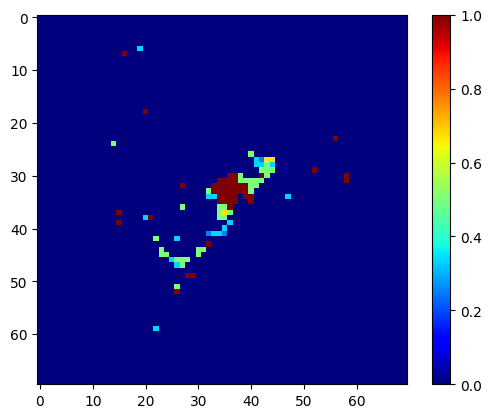

In [39]:
image_tp = np.flipud(image_tp.reshape(70, 70, 7, 7))
plt.imshow(image_tp[:, :, 0, 1], cmap='jet')
plt.colorbar()